# Snekmer Demo

In this notebook, we will demonstrate how to apply Snekmer toward the analysis of protein sequences.

## Getting Started

### Setup

First, install Snekmer using the instructions in the [user installation guide](https://github.com/PNNL-CompBio/Snekmer/).

Before running Snekmer, verify that files have been placed in an **_input_** directory placed at the same level as the **_config.yaml_** file. The assumed file directory structure is illustrated below.

    .
    ├── config.yaml
    ├── input
    │   ├── background
    │   │   ├── X.fasta
    │   │   ├── Y.fasta
    │   │   └── etc.
    │   ├── A.fasta
    │   ├── B.fasta
    │   └── etc.
    ├── output
    │   ├── ...
    │   └── ...
    
(Note: Snekmer automatically creates the **_output_** directory when creating output files, so there is no need to create this folder in advance. Additionally, inclusion of background sequences is optional, but is illustrated above for interested users.)

### Workflow

Snekmer proceeds through a defined workflow executed as individual steps on Snakemake. Two operation modes are available: `model` (supervised machine learning) and `cluster` (unsupervised clustering). The user should select the mode that best suits their individual use case.

<img src="https://raw.githubusercontent.com/PNNL-CompBio/Snekmer/main/resources/snekmer_workflow.png" width="70%" height="70%" >



### Notes on Using Snekmer

Snekmer assumes that the user will primarily process input files using the command line. For more detailed instructions, refer to the [README](https://github.com/PNNL-CompBio/Snekmer).

The basic process for running Snekmer is as follows:

1. Verify that your file directory structure is correct and that the top-level directory contains a **_config.yaml_** file.
    - A **_config.yaml_** template has been included in the Snekmer codebase at **_resources/config.yaml_**.
2. Modify the **_config.yaml_** with the desired parameters.
3. Use the command line to navigate to the directory containing both the **_config.yaml_** file and **_input_** directory.
4. Run `snekmer cluster` or `snekmer model`.

Depending on the selected operation mode, output files will vary.

In the following demo, we will go through the entire Snekmer workflow for supervised model-building (`snekmer model`). By the end of this demo, users should be familiar with how the code generally operates, how input files lead to output files, and the output for each individual step.

## Running Snekmer

### Setup

To set up the workflow such that operation mimics the command line implementation of Snekmer, we will initialize a dictionary (rather than a YAML file) and gather all input files. Input files are detected here using `glob.glob`, exactly as Snekmer performs input file detection.

In [1]:
# built-in imports
import itertools
import gzip
import json
import os
import pickle
from ast import literal_eval
from glob import glob
from datetime import datetime
from multiprocessing import Pool

# import from external libraries
import snekmer as skm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from Bio import SeqIO
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from snakemake.io import expand, directory

In [2]:
# define config
# (note: handled via config.yaml in the snekmer CLI workflow)

config = {
    
    # required parameters
    "k": 14,
    "alphabet": 0,  # choices 0-5 or names (see alphabet module), or None
    "min_rep_thresh": 1,
    "processes": 2,
    
    # optional parameters
    "start": False,
    "end": False,
    "nucleotide": False,
    "randomize_alphabet": False,
    "walk": False,
    "mode": None,

    # input handling
    "input": {
        "example_index_file": False,
        "feature_set": False,
        "file_extensions": ["fasta", "fna", "faa", "fa"],
        "regex": r"[a-z]{3}[A-Z]{1}",  # regex to parse family from filename
    },
    
    # output handling
    "output": {
        "nested_dir": False,  # if True, saves into {save_dir}/{alphabet name}/{k}
        "verbose": True, # if True, logs verbose outputs
        "format": "simple",  # choices: ["simple", "gist", "sieve"]
        "filter_duplicates": True,
        "n_terminal_file": False,
        "shuffle_n": False,
        "shuffle_sequences": False,
    },
    
    # scoring parameters
    "score": {
        "scaler": True,
        "scaler_kwargs": {"n": 0.25},
        "labels": None,
        "lname": None  # label name
    },
    
    # model parameters
    "model": {
        "n": 100,
        "cv": 5,
        "use_score": False,
        "random_state": None
    },
    
    # cluster parameters
    "cluster": {
        "method": "correlation",
        "params": {"t": 0.75, "criterion": "distance", "metric": "correlation", "method": "weighted"}
    }

}

## Rule 0: Get files

Before going through the workflow, we glob all filenames contained within the input directory that end in the pre-defined file extensions and/or the extension and `.gz`.

Note that while in this notebook, the path to the demo files is specified with the `input_dir` variable, the Snekmer CLI assumes that input files are stored according to the file structure specified above in the **Setup** section.

In [3]:
# collect all fasta-like files, unzipped filenames, and basenames
input_dir = "demo_files/input/"
input_files = glob(os.path.join(input_dir, "*"))
zipped = [fa for fa in input_files if fa.endswith(".gz")]
unzipped = [
    fa.rstrip(".gz")
    for fa, ext in itertools.product(input_files, config["input"]["file_extensions"])
    if fa.rstrip(".gz").endswith(f".{ext}")
]

print("zipped files:\t", zipped)
print("unzipped files:\t", unzipped)

zipped files:	 ['demo_files/input/NapD.faa.gz', 'demo_files/input/NapB.faa.gz']
unzipped files:	 ['demo_files/input/cNorB.faa', 'demo_files/input/NapD.faa', 'demo_files/input/NapB.faa', 'demo_files/input/nirS.faa']


Next, file paths are stripped of directory paths and extensions into the file base name, known in Snakemake as a file"s **wildcard**.

In [4]:
# map extensions to basename (basename.ext.gz -> {basename: ext})
UZ_MAP = {
    skm.utils.split_file_ext(f)[0]: skm.utils.split_file_ext(f)[1] for f in zipped
}

FA_MAP = {
    skm.utils.split_file_ext(f)[0]: skm.utils.split_file_ext(f)[1] for f in unzipped
}

UZS = list(UZ_MAP.keys())
FAS = list(FA_MAP.keys())

print("zipped filename wildcards:\t", UZS)
print("unzipped filename wildcards:\t", FAS)

zipped filename wildcards:	 ['NapD', 'NapB']
unzipped filename wildcards:	 ['cNorB', 'NapD', 'NapB', 'nirS']


In [5]:
# parse any background files
bg_files = glob(os.path.join(input_dir, "background", "*"))
if len(bg_files) > 0:
    bg_files = [skm.utils.split_file_ext(basename(f))[0] for f in bg_files]
NON_BGS, BGS = [f for f in FAS if f not in bg_files], bg_files

print("sample filename wildcards:\t", NON_BGS)
print("background filename wildcards:\t", BGS)

sample filename wildcards:	 ['cNorB', 'NapD', 'NapB', 'nirS']
background filename wildcards:	 []


Finally, the output (save) path is defined. (Note: this may change in future versions.)

In [6]:
# define output directory (and create if missing)
output_dir = "demo_files/output"

if not os.path.exists(output_dir):
    os.makedirs(output_dir)

print("output directory:\t", output_dir)

# validity check
skm.alphabet.check_valid(config["alphabet"])  # raises error if invalid alphabet

output directory:	 demo_files/output


## Rule 0.5: Unzip files

Any zipped files detected by the above are automatically unzipped. The zipped version of the file is copied into a separate subdirectory.

**Snakemake code:**

    # if any files are gzip compressed, unzip them
    rule unzip:
    input:
        join("input", "{uz}.gz")
    output:
        join("input", "{uz}")
    params:
        outdir=join("input", "zipped")
    shell:
        "mkdir {params.outdir} && gunzip -c {input} > {output} && mv {input} {params.outdir}/."
                
To run an analogous version of Snakemake syntax in Python, see below:

In [7]:
# if any files are gzip compressed, unzip them
for uz in UZS:
    input_ = os.path.join(input_dir, f"{uz}.{UZ_MAP[uz]}.gz")
    output_ = os.path.join(input_dir, f"{uz}.{UZ_MAP[uz]}")
    outdir = os.path.join(input_dir, "zipped")
    
    ! mkdir -p $outdir && gunzip -c $input_ > $output_ && mv $input_ $outdir/.

    print("input:\t", input_)
    print("output:\t", output_)

input:	 demo_files/input/NapD.faa.gz
output:	 demo_files/input/NapD.faa
input:	 demo_files/input/NapB.faa.gz
output:	 demo_files/input/NapB.faa


The above step successfully creates the unzipped output:

In [8]:
os.path.exists("demo_files/input/NapD.faa")

True

## Rule 1: Preprocess

In this step, we parse user-defined parameters into an appropriate format for subsequent pipeline steps.

Parameter options include:
- `filter_duplicates`: Remove duplicate sequences
- `map_function`: Define alphabet mappings
- `k`: Define kmer length
- `min_rep_thresh`: Set threshold for minimum replicates required to include a feature in the final feature space
- `shuffle_sequences`: Shuffle sequences
    - `shuffle_n`: Define shuffle
- `example_index_file`: Use example index file to define feature space
- `filter_sequences`: Optionally filter sequences
- `start` and `end`: Define sequence start and end points
- `nucleotide`: Allow nucleotide mapping

The Snakemake code is not shown due to length, but the converted Python-ized code is shown below:

In [9]:
# read and process parameters from config
for fa in FAS:

    # define i/o for each detected file
    input_fasta = os.path.join(input_dir, f"{fa}.{FA_MAP[fa]}")
    output_data = os.path.join(output_dir, "processed", f"{fa}.json")
    output_desc = os.path.join(output_dir, "processed", f"{fa}_description.json")

    print("input file:\t", input_fasta)
    print("output file:\t", output_data)

    start_time = datetime.now()

    # read fasta file
    seq_list, id_list = skm.io.read_fasta(input_fasta)

    # if random alphabet specified, implement randomization
    if config["randomize_alphabet"]:
        rand_alphabet = skm.transform.randomize_alphabet(config["alphabet"])
        alphabet = [residues, map_name, rand_alphabet]
    else:
        alphabet = config["alphabet"]
        if alphabet == "None":
            alphabet = None

    # maximize kmer basis set for clustering
    if config["mode"] == "cluster":
        min_rep_thresh = 0  # minimum kmer repetitions
    else:
        min_rep_thresh = config["min_rep_thresh"]

    # if no feature set is specified, define feature space
    if not config["input"]["feature_set"]:
        # prefilter fasta to cut down on the size of feature set
        filter_dict = skm.features.define_feature_space(
            {k: v for k, v in zip(id_list, seq_list)},
            config["k"],
            alphabet=alphabet,
            start=config["start"],
            end=config["end"],
            min_rep_thresh=min_rep_thresh,
            verbose=config["output"]["verbose"],
            processes=config["processes"],
        )
        filter_list = list(filter_dict.keys())
        assert len(filter_list) > 0, "Invalid feature space; terminating."
    else:
        # read in list of ids to use from file; NO FORMAT CHECK
        filter_list = skm.io.read_output_kmers(config["input"]["feature_set"])

    # optional indexfile with IDs of good feature output examples
    if config["input"]["example_index_file"]:
        example_index = skm.io.read_example_index(config["input"]["example_index_file"])
    else:
        example_index = {}

    # loop thru seqs, apply input params to preprocess seq list
    seen = []  # filter duplicates
    save_data = dict()

    # define recursive and nonrecursive saving patterns for params
    recursive = ["sequences", "ids", "residues"]
    nonrecursive = ["alphabet", "k", "example_index", "filter_list"]
    all_dsets = recursive + nonrecursive

    # parse through sequences in file
    for i in range(len(seq_list)):
        seq = seq_list[i]
        sid = id_list[i]

        # ignore duplicate ids
        if config["output"]["filter_duplicates"] and sid in seen:
            continue
        seen.append(sid)

        seqs = [seq]
        sids = [sid]

        # shuffle the N-terminal sequence n times
        if config["output"]["shuffle_n"]:
            example_index[sid] = 1.0
            scid_list, scramble_list, example_index = skm.transform.scramble_sequence(
                sid,
                seq[:30],
                n=config["output"]["shuffle_n"],
                example_index=example_index,
            )
            seqs += scramble_list
            sids += scid_list

            # include shuffled sequences in output
            if config["output"]["shuffle_sequences"]:
                filename = join(output_dir, "shuffled", fa, "%s_shuffled.fasta" % sid)
                if not os.path.exists(os.path.dirname(filename)):
                    os.makedirs(os.path.dirname(filename))
                with open(filename, "w") as f:
                    for i in range(len(sids)):
                        f.write(">%s\n%s\n" % (sids[i], seqs[i]))

        # run SIEVE on the wt and each shuffled sequence
        if config["output"]["n_terminal_file"]:
            sids_n, seqs_n = skm.transform.make_n_terminal_fusions(
                sid, config["output"]["n_terminal_file"]
            )
            seqs += seqs_n
            sids += sids_n
        residues = None
        if config["nucleotide"]:
            residues = "ACGT"

        # populate dictionary for json save file
        to_save = [seqs, sids, residues]
        save_label = recursive
        for dset, label in zip(to_save, save_label):
            if label in save_data.keys() and save_data[label] is not None:
                save_data[label] = save_data[label] + dset
            else:
                save_data[label] = dset

    # save variables not generated in loop
    for dset, label in zip(
        [alphabet, config["k"], example_index, filter_list], nonrecursive
    ):
        save_data[label] = dset

    # save all parameters into json
    if not os.path.exists(os.path.join(output_dir, "processed")):
        os.makedirs(os.path.join(output_dir, "processed"))
    with open(output_data, "w") as f:
        json.dump(save_data, f)

    # read and save fasta descriptions into dataframe
    try:
        desc = skm.utils.parse_fasta_description(input_fasta)
        desc.to_json(output_desc)
    except AttributeError:  # if no description exists > empty df
        pd.DataFrame([]).to_json(output_desc)

    # record script runtime (handled by skm.utils.log_runtime in CLI)
    end_time = datetime.now()
    print(f"start time:\t{start_time}")
    print(f"end time:\t{end_time}")
    print(f"total time:\t{skm.utils.format_timedelta(end_time - start_time)}\n")

input file:	 demo_files/input/cNorB.faa
output file:	 demo_files/output/processed/cNorB.json
Feature space: 6523 kmers with more than 1 representation in 92 sequences
start time:	2022-02-23 12:44:50.304774
end time:	2022-02-23 12:44:52.156967
total time:	0h 00m 01.852s

input file:	 demo_files/input/NapD.faa
output file:	 demo_files/output/processed/NapD.json
Feature space: 8666 kmers with more than 1 representation in 253 sequences
start time:	2022-02-23 12:44:52.157216
end time:	2022-02-23 12:44:54.099395
total time:	0h 00m 01.942s

input file:	 demo_files/input/NapB.faa
output file:	 demo_files/output/processed/NapB.json
Feature space: 8471 kmers with more than 1 representation in 226 sequences
start time:	2022-02-23 12:44:54.099656
end time:	2022-02-23 12:44:56.035277
total time:	0h 00m 01.936s

input file:	 demo_files/input/nirS.faa
output file:	 demo_files/output/processed/nirS.json
Feature space: 6512 kmers with more than 1 representation in 49 sequences
start time:	2022-02-23 1

In [10]:
# check to see if output files were created
for fa in FAS:
    print(os.path.exists(os.path.join(output_dir, "processed", f"{fa}.json")))

True
True
True
True


## Rule 2: Generate kmer labels

In this step, kmer labels for the kmers in the generated feature space are saved.

As previously, the Python-ized version of this Snakemake rule is demonstrated below:

In [11]:
for fa in FAS:
    input_params = os.path.join(output_dir, "processed", f"{fa}.json")
    output_labels = os.path.join(output_dir, "labels", f"{fa}.txt")
    print("input file:\t", input_params)
    print("output file:\t", output_labels)

    start_time = datetime.now()

    # read processed features
    with open(input_params, "r") as f:
        params = json.load(f)

    if not os.path.exists(os.path.join(output_dir, "labels")):
        os.makedirs(os.path.join(output_dir, "labels"))

    # generate labels only
    labels = skm.transform.generate_labels(
        config["k"], alphabet=params["alphabet"], filter_list=params["filter_list"]
    )
    if config["output"]["format"] == "simple":
        skm.features.output_features(output_labels, "matrix", labels=labels)

    # record script runtime
    end_time = datetime.now()
    print(f"start time:\t{start_time}")
    print(f"end time:\t{end_time}")
    print(f"total time:\t{skm.utils.format_timedelta(end_time - start_time)}\n")

input file:	 demo_files/output/processed/cNorB.json
output file:	 demo_files/output/labels/cNorB.txt
start time:	2022-02-23 12:44:57.739752
end time:	2022-02-23 12:44:57.745940
total time:	0h 00m 00.6s

input file:	 demo_files/output/processed/NapD.json
output file:	 demo_files/output/labels/NapD.txt
start time:	2022-02-23 12:44:57.746090
end time:	2022-02-23 12:44:57.753299
total time:	0h 00m 00.7s

input file:	 demo_files/output/processed/NapB.json
output file:	 demo_files/output/labels/NapB.txt
start time:	2022-02-23 12:44:57.753509
end time:	2022-02-23 12:44:57.760861
total time:	0h 00m 00.7s

input file:	 demo_files/output/processed/nirS.json
output file:	 demo_files/output/labels/nirS.txt
start time:	2022-02-23 12:44:57.761023
end time:	2022-02-23 12:44:57.766145
total time:	0h 00m 00.5s



In [12]:
# check that output files were created correctly
for fa in FAS:
    print(os.path.exists(os.path.join(output_dir, "labels", f"{fa}.txt")))

True
True
True
True


## Rule 3: Standardize kmers

In this step, the feature spaces for each individual file are used to parse all files in the directory. For instance, the `12485-2500Genomes-nrfH_protein` feature set is used to kmerize all sequences in both `12485-2500Genomes-nrfH_protein` and `AmoA_AOA` sets, and then the `AmoA_AOA` feature set is used to kmerize all sequences in both sequence files.

As previously, the Python-ized version of this Snakemake rule is demonstrated below:

In [13]:
for fa in FAS:
    input_kmers = os.path.join(output_dir, "labels", f"{fa}.txt")
    input_params = os.path.join(output_dir, "processed", f"{fa}.json")
    input_fastas = unzipped
    output_files = expand(
        os.path.join(output_dir, "features", f"{fa}", "{fa2}.json.gz"), fa2=FAS
    )
    print("input file:\t", input_kmers)
    print("output files:\t", output_files)

    if not os.path.exists(os.path.join(output_dir, "features", f"{fa}")):
        os.makedirs(os.path.join(output_dir, "features", f"{fa}"))

    start_time = datetime.now()

    # get kmers for this particular set of sequences
    kmers = skm.io.read_output_kmers(input_kmers)

    # read processed features
    with open(input_params, "r") as f:
        params = json.load(f)

    # sort i/o lists to match wildcard order
    fastas = sorted(input_fastas)
    outfiles = sorted(output_files)

    # revectorize based on full kmer list
    for i, fa in enumerate(fastas):
        results = {"seq_id": [], "vector": []}
        seq_list, id_list = skm.io.read_fasta(fa)
        for seq, sid in zip(seq_list, id_list):
            results["seq_id"] += [sid]
            results["vector"] += [
                skm.transform.vectorize_string(
                    seq,
                    config["k"],
                    params["alphabet"],
                    start=config["start"],
                    end=config["end"],
                    filter_list=kmers,
                    verbose=False,  # suppress for batch processing
                )
            ]
        with gzip.open(outfiles[i], "wt", encoding="ascii") as zipfile:
            json.dump(results, zipfile)

    # record script runtime
    end_time = datetime.now()
    print(f"start time:\t{start_time}")
    print(f"end time:\t{end_time}")
    print(f"total time:\t{skm.utils.format_timedelta(end_time - start_time)}\n")

input file:	 demo_files/output/labels/cNorB.txt
output files:	 ['demo_files/output/features/cNorB/cNorB.json.gz', 'demo_files/output/features/cNorB/NapD.json.gz', 'demo_files/output/features/cNorB/NapB.json.gz', 'demo_files/output/features/cNorB/nirS.json.gz']
start time:	2022-02-23 12:44:57.782018
end time:	2022-02-23 12:45:11.104949
total time:	0h 00m 13.323s

input file:	 demo_files/output/labels/NapD.txt
output files:	 ['demo_files/output/features/NapD/cNorB.json.gz', 'demo_files/output/features/NapD/NapD.json.gz', 'demo_files/output/features/NapD/NapB.json.gz', 'demo_files/output/features/NapD/nirS.json.gz']
start time:	2022-02-23 12:45:11.105667
end time:	2022-02-23 12:45:28.747753
total time:	0h 00m 17.642s

input file:	 demo_files/output/labels/NapB.txt
output files:	 ['demo_files/output/features/NapB/cNorB.json.gz', 'demo_files/output/features/NapB/NapD.json.gz', 'demo_files/output/features/NapB/NapB.json.gz', 'demo_files/output/features/NapB/nirS.json.gz']
start time:	2022-02

In [14]:
# check that output directories were created correctly
for fa in FAS:
    print(os.path.exists(os.path.join(output_dir, "features", f"{fa}")))

True
True
True
True


In [15]:
# check contents of each output directory
for fa in FAS:
    print(sorted(glob(os.path.join(output_dir, "features", f"{fa}", "*"))))

['demo_files/output/features/cNorB/NapB.json.gz', 'demo_files/output/features/cNorB/NapD.json.gz', 'demo_files/output/features/cNorB/cNorB.json.gz', 'demo_files/output/features/cNorB/nirS.json.gz']
['demo_files/output/features/NapD/NapB.json.gz', 'demo_files/output/features/NapD/NapD.json.gz', 'demo_files/output/features/NapD/cNorB.json.gz', 'demo_files/output/features/NapD/nirS.json.gz']
['demo_files/output/features/NapB/NapB.json.gz', 'demo_files/output/features/NapB/NapD.json.gz', 'demo_files/output/features/NapB/cNorB.json.gz', 'demo_files/output/features/NapB/nirS.json.gz']
['demo_files/output/features/nirS/NapB.json.gz', 'demo_files/output/features/nirS/NapD.json.gz', 'demo_files/output/features/nirS/cNorB.json.gz', 'demo_files/output/features/nirS/nirS.json.gz']


## Rule 4: Score features

In this penultimate step, the files parsed into each feature space are scored for their faithful differentiation of each protein family, and then clustering is performed on the individual sequences. The results are all collated and stored into a Pandas DataFrame (`pandas.DataFrame` object).

As previously, the Python-ized version of this Snakemake rule is demonstrated below:

In [16]:
for fa in FAS:
    input_kmers = os.path.join(output_dir, "labels", f"{fa}.txt")
    input_files = expand(
        os.path.join(output_dir, "features", f"{fa}", "{fa2}.json.gz"), fa2=FAS
    )
    output_df = os.path.join(output_dir, "features", f"{fa}.csv.gz")
    output_scores = os.path.join(output_dir, "score", f"{fa}.csv.gz")
    output_scorer = os.path.join(output_dir, "score", f"{fa}.pkl")
    print("input files:\t", input_files)
    print("output files:\t", [output_df, output_scores, output_scorer])

    if not os.path.exists(os.path.join(output_dir, "score")):
        os.makedirs(os.path.join(output_dir, "score"))

    start_time = datetime.now()
    print(f"start time:\t{start_time}")

    # get kmers for this particular set of sequences
    kmers = skm.io.read_output_kmers(input_kmers)

    # parse all data
    label = config["score"]["lname"]
    data = skm.io.vecfiles_to_df(
        input_files, labels=config["score"]["labels"], label_name=label
    )
    data["background"] = [
        skm.utils.split_file_ext(f)[0] in BGS for f in data["filename"]
    ]

    timepoint = datetime.now()
    print(f"vecfiles_to_df time:\t{skm.utils.format_timedelta(timepoint - start_time)}")

    # parse family names and only add if some are valid
    families = [
        skm.utils.get_family(
            skm.utils.split_file_ext(fn)[0], regex=config["input"]["regex"]
        )
        for fn in data["filename"]
    ]
    if any(families):
        label = "family"
        data[label] = families

    # binary T/F for classification into family
    family = skm.utils.get_family(fa)
    binary_labels = [True if value == family else False for value in data[label]]

    # define k-fold split indices
    if config["model"]["cv"] > 1:
        cv = StratifiedKFold(n_splits=config["model"]["cv"], shuffle=True)

        # stratify splits by [0,1] family assignment
        for n, (i_train, _) in enumerate(cv.split(data["vector"], binary_labels)):
            data[f"train_cv-{n + 1:02d}"] = [idx in i_train for idx in data.index]

    elif config["model"]["cv"] in [0, 1]:
        i_train, _ = train_test_split(data.index, stratify=binary_labels)
        data["train"] = [idx in i_train for idx in data.index]

    # generate family scores and object
    scorer = skm.model.KmerScorer()
    scorer.fit(
        kmers,
        data,
        skm.utils.get_family(fa, regex=config["input"]["regex"]),
        label_col=label,
        **config["score"]["scaler_kwargs"],
    )

    # append scored sequences to dataframe
    data = data.merge(
        pd.DataFrame(scorer.scores["sample"]), left_index=True, right_index=True
    )
    if data.empty:
        raise ValueError("Blank df")

    # save score loadings
    class_probabilities = (
        pd.DataFrame(scorer.probabilities, index=scorer.kmers.basis)
        .reset_index()
        .rename(columns={"index": "kmer"})
    )

    # save all files to respective outputs
    delete_cols = ["vec", "vector"]
    for col in delete_cols:
        # if col in data.columns:
        #     data = data.drop(columns=col)
        if col in class_probabilities.columns:
            class_probabilities = class_probabilities.drop(columns=col)
    data.to_csv(output_df, index=False, compression="gzip")
    class_probabilities.to_csv(output_scores, index=False, compression="gzip")
    with open(output_scorer, "wb") as f:
        pickle.dump(scorer, f)

    # record script runtime
    end_time = datetime.now()
    print(f"end time:\t{end_time}")
    print(f"total time:\t{skm.utils.format_timedelta(end_time - start_time)}\n")

input files:	 ['demo_files/output/features/cNorB/cNorB.json.gz', 'demo_files/output/features/cNorB/NapD.json.gz', 'demo_files/output/features/cNorB/NapB.json.gz', 'demo_files/output/features/cNorB/nirS.json.gz']
output files:	 ['demo_files/output/features/cNorB.csv.gz', 'demo_files/output/score/cNorB.csv.gz', 'demo_files/output/score/cNorB.pkl']
start time:	2022-02-23 12:45:58.606358
vecfiles_to_df time:	0h 00m 00.527s
end time:	2022-02-23 12:46:01.788066
total time:	0h 00m 03.182s

input files:	 ['demo_files/output/features/NapD/cNorB.json.gz', 'demo_files/output/features/NapD/NapD.json.gz', 'demo_files/output/features/NapD/NapB.json.gz', 'demo_files/output/features/NapD/nirS.json.gz']
output files:	 ['demo_files/output/features/NapD.csv.gz', 'demo_files/output/score/NapD.csv.gz', 'demo_files/output/score/NapD.pkl']
start time:	2022-02-23 12:46:01.788697
vecfiles_to_df time:	0h 00m 00.699s
end time:	2022-02-23 12:46:05.816322
total time:	0h 00m 04.28s

input files:	 ['demo_files/outpu

In [17]:
# check that output files were created correctly
for fa in FAS:
    print(os.path.exists(os.path.join(output_dir, "features", f"{fa}.csv.gz")))

True
True
True
True


The contents of one of these dataframes is as follows:

In [18]:
example_family = np.random.choice(FAS)
print("example family:\t", example_family)

# show relevant subset of columns
example_score_output = pd.read_csv(
    os.path.join(output_dir, "features", f"{example_family}.csv.gz")
)[["filename", "seq_id", "family", f"{example_family}_score"]]
example_score_output

example family:	 cNorB


,filename,seq_id,family,cNorB_score
0,cNorB.json.gz,WP_004255833.1,cNorB,0.788182
1,cNorB.json.gz,WP_043108184.1,cNorB,0.745808
2,cNorB.json.gz,WP_011311073.1,cNorB,0.811925
3,cNorB.json.gz,WP_014238124.1,cNorB,0.773484
4,cNorB.json.gz,WP_013029258.1,cNorB,0.717490
...,...,...,...,...
615,nirS.json.gz,WP_011383805.1,nirS,0.036300
616,nirS.json.gz,WP_049724801.1,nirS,0.056875
617,nirS.json.gz,WP_041099757.1,nirS,0.037763
618,nirS.json.gz,WP_015258444.1,nirS,0.059967


Text(0, 0.5, 'cNorB Score')

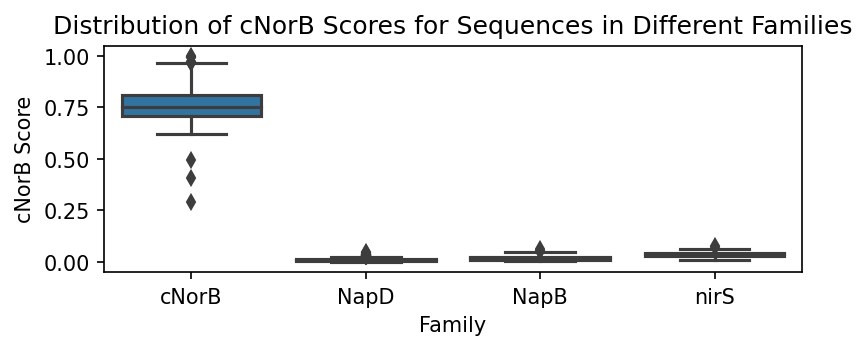

In [19]:
plt.figure(figsize=(6, 2), dpi=150)
ax = sns.boxplot(x="family", y=f"{example_family}_score", data=example_score_output)

ax.set_title(
    f"Distribution of {example_family} Scores for Sequences in Different Families"
)
ax.set_xlabel("Family")
ax.set_ylabel(f"{example_family} Score")

We can assess how well the scores perform using the weights determined for each family. Note that it is immediately obvious that the `cNorB` scoring method performs well in identifying cNorB sequences versus the NapD, NapB, and nirS sequences.

Not all family scoring methods perform similarly well in terms of differentation between sequences belonging to different families. The user can manually inspect the other families, but we note that the NapD family and NapB family scorers are worse at generating high separation between the in-family and out-of-family sequences. Differing scorer performances can be attributed to a variety of factors, e.g. parameters such as the alphabet and k, existing levels of similarity between sequences in different families, etc.

The probabilities and scores assigned to each feature in the kmer set is also computed and output into a dataframe:

In [20]:
print(example_family)
pd.read_csv(os.path.join(output_dir, "score", f"{example_family}.csv.gz"))

cNorB


,kmer,sample,background
0,VSSSSSVVVVSSSV,0.014936,NaN
1,SSSSSVVVVSSSVV,0.205204,NaN
2,SSSSVVVVSSSVVV,0.206522,NaN
3,SSSVVVVSSSVVVV,0.141304,NaN
4,SSVVVVSSSVVVVV,0.141304,NaN
...,...,...,...
6518,SVSSSVSVSSSSSS,-0.031662,NaN
6519,VSSSVSVSSSSSSS,-0.036418,NaN
6520,SSSVSVSSSSSSSS,-0.047746,NaN
6521,VSVSSSVSVVSVVS,0.004067,NaN


## Rule 5: Build supervised machine learning models

Finally, models are constructed which accept the pre-determined family scores as input and train logistic regression models to output putative in-family assignment for a given sequence. The model can also be used to approximate the probability that a given sequence belongs to the family of interest.

Each model is further validated using K-fold cross-validation, and the results from each cross-validation split are summarized in figures depicting the Receiver-Operator Characteristics (ROC) Curve and Precision-Recall (PR) Curve. In the following example, `K=5`.

The code, as adapted for presentation in a Jupyter notebook, is included below:

input files:	 [['demo_files/output/features/cNorB/cNorB.json.gz', 'demo_files/output/features/cNorB/NapD.json.gz', 'demo_files/output/features/cNorB/NapB.json.gz', 'demo_files/output/features/cNorB/nirS.json.gz'], 'demo_files/output/features/cNorB.csv.gz', 'demo_files/output/score/cNorB.csv.gz', 'demo_files/output/labels/cNorB.txt']
output files:	 ['demo_files/output/model/results/cNorB.csv', 'demo_files/output/model/cNorB.pkl']
start time:	2022-02-23 12:46:13.520848


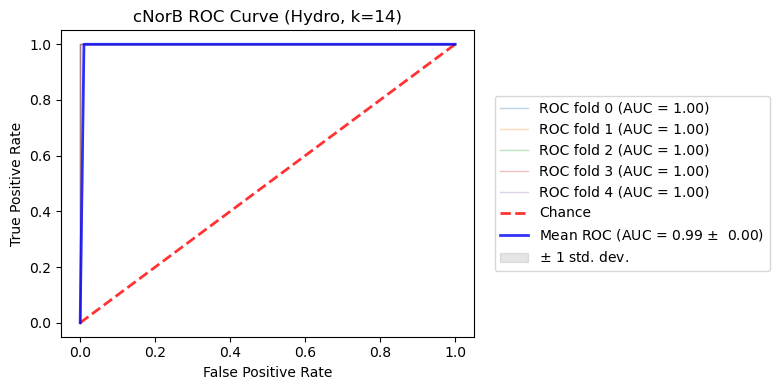

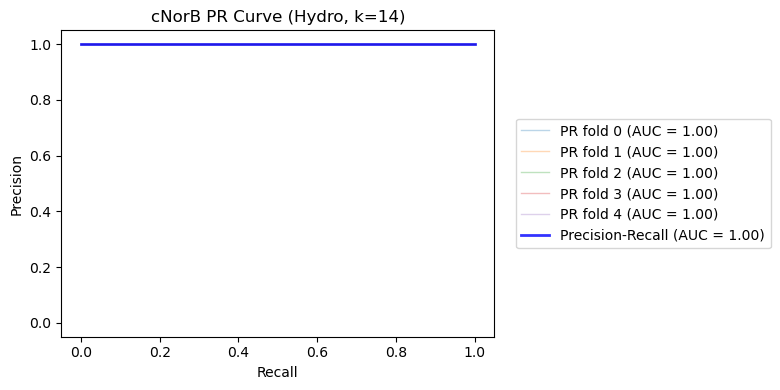

end time:	2022-02-23 12:46:30.848994
total time:	0h 00m 17.328s

input files:	 [['demo_files/output/features/NapD/cNorB.json.gz', 'demo_files/output/features/NapD/NapD.json.gz', 'demo_files/output/features/NapD/NapB.json.gz', 'demo_files/output/features/NapD/nirS.json.gz'], 'demo_files/output/features/NapD.csv.gz', 'demo_files/output/score/NapD.csv.gz', 'demo_files/output/labels/NapD.txt']
output files:	 ['demo_files/output/model/results/NapD.csv', 'demo_files/output/model/NapD.pkl']
start time:	2022-02-23 12:46:30.849495


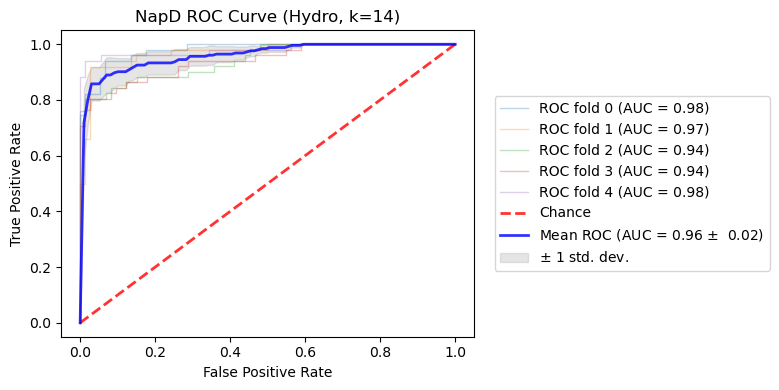

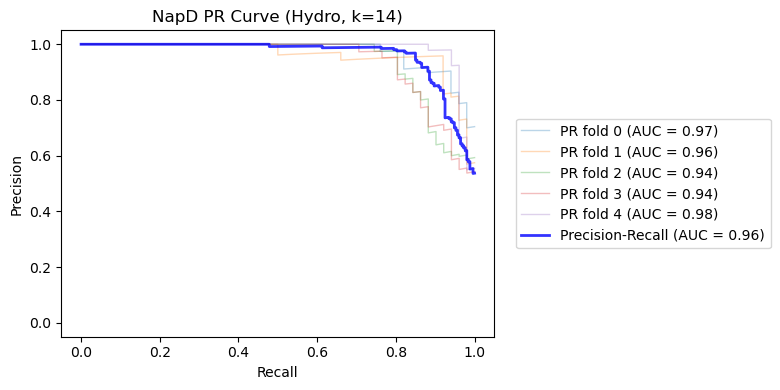

end time:	2022-02-23 12:46:56.335807
total time:	0h 00m 25.486s

input files:	 [['demo_files/output/features/NapB/cNorB.json.gz', 'demo_files/output/features/NapB/NapD.json.gz', 'demo_files/output/features/NapB/NapB.json.gz', 'demo_files/output/features/NapB/nirS.json.gz'], 'demo_files/output/features/NapB.csv.gz', 'demo_files/output/score/NapB.csv.gz', 'demo_files/output/labels/NapB.txt']
output files:	 ['demo_files/output/model/results/NapB.csv', 'demo_files/output/model/NapB.pkl']
start time:	2022-02-23 12:46:56.336302


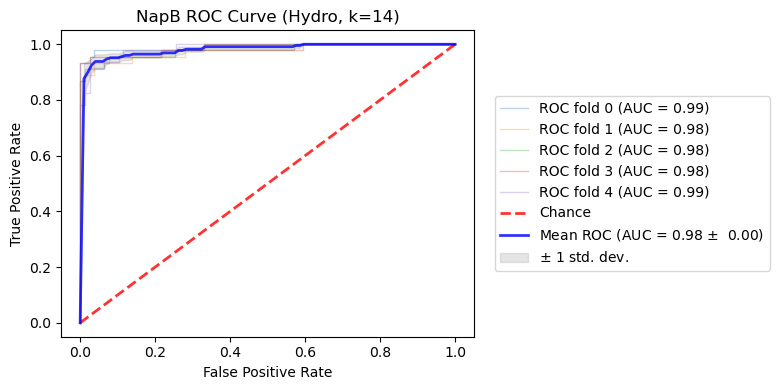

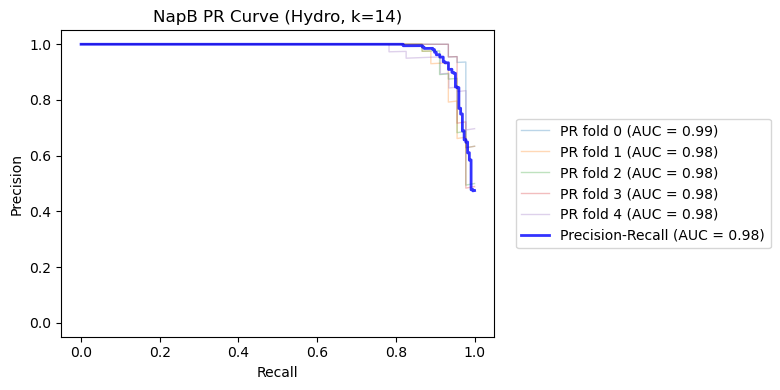

end time:	2022-02-23 12:47:21.844411
total time:	0h 00m 25.508s

input files:	 [['demo_files/output/features/nirS/cNorB.json.gz', 'demo_files/output/features/nirS/NapD.json.gz', 'demo_files/output/features/nirS/NapB.json.gz', 'demo_files/output/features/nirS/nirS.json.gz'], 'demo_files/output/features/nirS.csv.gz', 'demo_files/output/score/nirS.csv.gz', 'demo_files/output/labels/nirS.txt']
output files:	 ['demo_files/output/model/results/nirS.csv', 'demo_files/output/model/nirS.pkl']
start time:	2022-02-23 12:47:21.844939


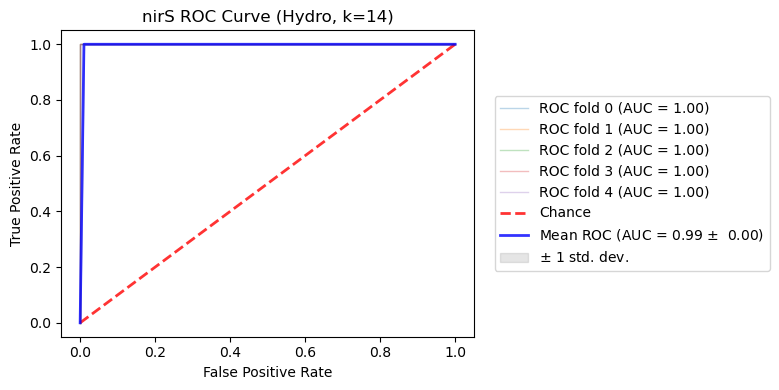

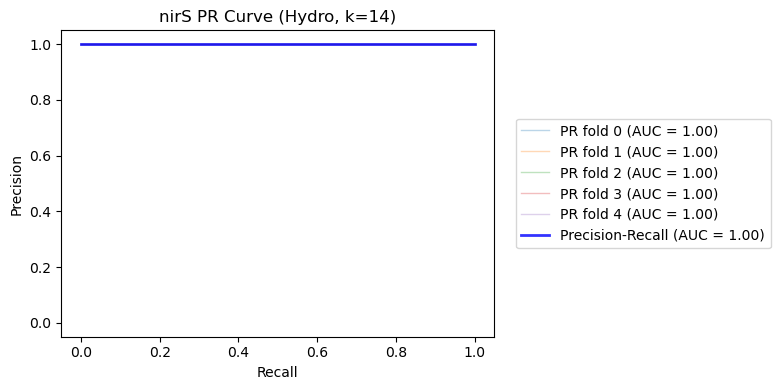

end time:	2022-02-23 12:47:40.319948
total time:	0h 00m 18.475s



In [21]:
for fa in FAS:
    # define all input and output files
    input_files = expand(
        os.path.join(output_dir, "features", f"{fa}", "{fa2}.json.gz"), fa2=FAS
    )
    input_data = os.path.join(output_dir, "features", f"{fa}.csv.gz")
    input_scores = os.path.join(output_dir, "score", f"{fa}.csv.gz")
    input_kmers = os.path.join(output_dir, "labels", f"{fa}.txt")
    output_model = os.path.join(output_dir, "model", f"{fa}.pkl")
    output_results = os.path.join(output_dir, "model", "results", f"{fa}.csv")
    print("input files:\t", [input_files, input_data, input_scores, input_kmers])
    print("output files:\t", [output_results, output_model])

    if not os.path.exists(os.path.join(output_dir, "model", "results")):
        os.makedirs(os.path.join(output_dir, "model", "results"))

    start_time = datetime.now()
    print(f"start time:\t{start_time}")

    # load all input data and encode rule-wide variables
    data = pd.read_csv(input_data)
    data["vector"] = [
        literal_eval(vec) if isinstance(vec, str) else vec for vec in data["vector"]
    ]
    scores = pd.read_csv(input_scores)
    family = skm.utils.get_family(
        skm.utils.split_file_ext(input_scores)[0], regex=config["input"]["regex"]
    )
    kmers = skm.io.read_output_kmers(input_kmers)
    all_families = [
        skm.utils.get_family(
            skm.utils.split_file_ext(f)[0], regex=config["input"]["regex"]
        )
        for f in input_files
    ]
    cv = config["model"]["cv"]

    # process vector data
    label = "family"

    # prevent kmer NA being read as np.nan
    if config["k"] == 2:
        scores["kmer"] = scores["kmer"].fillna("NA")

    # get alphabet name
    if config["alphabet"] in skm.alphabet.ALPHABET_ORDER.keys():
        alphabet_name = skm.alphabet.ALPHABET_ORDER[config["alphabet"]].capitalize()
    else:
        alphabet_name = str(config["alphabet"]).capitalize()

    # create dataframe skeleton for AUC per family
    results = {
        "family": [],
        "alphabet_name": [],
        "k": [],
        "scoring": [],
        "score": [],
        "cv_split": [],
    }

    # generate [0, 1] labels for binary family assignment
    binary_labels = [True if value == family else False for value in data["family"]]
    le = LabelEncoder()
    le.fit(binary_labels)

    # set and format input and label arrays; initialize model objs
    X_all = data[f"{family}_score"].values.reshape(-1, 1)
    y_all = le.transform(binary_labels).ravel()

    # set random seed if specified
    rng = np.random.default_rng()
    random_state = rng.integers(low=0, high=32767)  # max for int16
    if str(config["model"]["random_state"]) != "None":
        random_state = config["model"]["random_state"]

    # set and format input and label arrays; initialize model objs
    X, y = {i: {} for i in range(cv)}, {i: {} for i in range(cv)}
    for n in range(cv):

        # remove score cols that were generated from full dataset
        unscored_cols = [col for col in list(data.columns) if "_score" not in col]

        # filter data by training data per split
        i_train = data[data[f"train_cv-{n + 1:02d}"]].index
        i_test = data[~data[f"train_cv-{n + 1:02d}"]].index
        df_train = data.iloc[i_train][unscored_cols].reset_index(drop=True)
        df_test = data.iloc[i_test][unscored_cols].reset_index(drop=True)
        df_train_labels = [
            True if value == family else False for value in df_train["family"]
        ]
        df_test_labels = [
            True if value == family else False for value in df_test["family"]
        ]

        # score kmers separately per split
        scorer = skm.model.KmerScorer()
        scorer.fit(
            kmers,
            df_train,
            family,
            label_col=label,
            **config["score"]["scaler_kwargs"],
        )

        # append scored sequences to dataframe
        df_train = df_train.merge(
            pd.DataFrame(scorer.scores["sample"]), left_index=True, right_index=True
        )
        if df_train.empty:
            raise ValueError("Blank df")
        df_test = df_test.merge(
            pd.DataFrame(
                scorer.predict(skm.model.to_feature_matrix(df_test["vector"]), kmers)
            ),
            left_index=True,
            right_index=True,
        ).rename(columns={0: f"{family}_score"})

        # save score loadings
        scores = (
            pd.DataFrame(scorer.probabilities, index=scorer.kmers.basis)
            .reset_index()
            .rename(columns={"index": "kmer"})
        )

        # save X,y array data for plot
        X[n]["train"] = df_train[f"{family}_score"].values.reshape(-1, 1)
        y[n]["train"] = le.transform(df_train_labels).ravel()

        X[n]["test"] = df_test[f"{family}_score"].values.reshape(-1, 1)
        y[n]["test"] = le.transform(df_test_labels).ravel()

    # ROC-AUC figure
    clf = LogisticRegression(
        random_state=random_state, solver="liblinear", class_weight="balanced"
    )
    fig, ax, auc_rocs = skm.plot.cv_roc_curve(
        clf,
        X,
        y,
        title=(f"{family} ROC Curve ({alphabet_name},  k={config['k']})"),
        dpi=100,
    )

    # collate ROC-AUC results
    results["family"] += [family] * cv
    results["alphabet_name"] += [alphabet_name.lower()] * cv
    results["k"] += [config["k"]] * cv
    results["scoring"] += ["roc_auc"] * cv
    results["score"] += auc_rocs
    results["cv_split"] += [i + 1 for i in range(cv)]

    # display and ROC-AUC figure
    plt.tight_layout()
    plt.show()

    # PR-AUC figure
    fig, ax, pr_aucs = skm.plot.cv_pr_curve(
        clf,
        X,
        y,
        title=(f"{family} PR Curve ({alphabet_name}, k={config['k']})"),
        dpi=100,
    )

    # collate PR-AUC results
    results["family"] += [family] * cv
    results["alphabet_name"] += [alphabet_name.lower()] * cv
    results["k"] += [config["k"]] * cv
    results["scoring"] += ["pr_auc"] * cv
    results["score"] += pr_aucs
    results["cv_split"] += [i + 1 for i in range(cv)]

    # display PR-AUC figure
    plt.tight_layout()
    plt.show()

    # save model
    clf.fit(X_all, y_all)
    with open(output_model, "wb") as save_model:
        pickle.dump(clf, save_model)

    # save full results
    pd.DataFrame(results).to_csv(output_results, index=False)

    # record script runtime
    end_time = datetime.now()
    print(f"end time:\t{end_time}")
    print(f"total time:\t{skm.utils.format_timedelta(end_time - start_time)}\n")


In [22]:
# check that output files were created correctly
for fa in FAS:
    print(os.path.exists(os.path.join(output_dir, "model", "results", f"{fa}.csv")))

True
True
True
True


The models are objects stored as pickle files (.PKL) that can be applied elsewhere, e.g. to a new set of unknown sequences.

# Snekmer Application

## Evaluate Unknown Sequences

Say a user trains the four models above, and would then like to score and evaluate sequences with unknown family assignments. The user can use the kmer basis set for the desired family to create kmer vectors for the unknown sequences, then apply the family scorer to the vectorized unknown sequences, and finally use the model to predict family assignments for the unknown sequences.

These steps are illustrated below:

In [23]:
print("example family:\t", example_family)

# define the basis set for the example family
new_basis_file = f"demo_files/output/labels/{example_family}.txt"
new_basis = skm.io.read_output_kmers(new_basis_file)

# load pre-trained scorer and model
model_file = f"demo_files/output/model/{example_family}.pkl"
with open(model_file, "rb") as mf:
    model = pickle.load(mf)
scorer_file = f"demo_files/output/score/{example_family}.pkl"
with open(scorer_file, "rb") as sf:
    scorer = pickle.load(sf)

# define set of unknown vectors
new_vec_files = glob("demo_files/search/*.fasta")

# kmerize all vectors and use scorer + model to predict
results = list()
for fasta in new_vec_files:
    seq_list, id_list = skm.io.read_fasta(fasta)

    # kmerize unknown vectors according to example family basis set
    # NOTE: this step has been simplified for demo purposes, but
    #       for batch processing, users should use the Snekmer CLI
    #       (`snekmer model --until vectorize` and specify input
    #       feature set specified in the config.yaml)
    new_vec_df = {"seq_id": [], "vector": []}
    for seq, sid in zip(seq_list, id_list):
        new_vec_df["seq_id"] += [sid]
        new_vec_df["vector"] += [
            skm.transform.vectorize_string(
                seq,
                config["k"],
                params["alphabet"],
                start=config["start"],
                end=config["end"],
                filter_list=new_basis,
                verbose=False,  # suppress for batch processing
            )
        ]
    new_vec_df = pd.DataFrame(new_vec_df)
    new_vecs = skm.utils.to_feature_matrix(new_vec_df["vector"].values)

    # score unknown sequences using pre-trained scorer
    new_scores = scorer.predict(new_vecs, new_basis)

    # predict probabilities and classes of new vecs using model
    predictions = model.predict(new_scores.reshape(-1, 1))
    predicted_scores = model.predict_proba(new_scores.reshape(-1, 1))

    # display results (score, family assignment, and probability)
    new_vec_df[f"{example_family}_score"] = new_scores  # scorer output
    new_vec_df[example_family] = [True if p == 1 else False for p in predictions]
    new_vec_df[f"{example_family}_probability"] = [p[1] for p in predicted_scores]
    new_vec_df["filename"] = os.path.basename(fasta)
    results.append(new_vec_df)

results = pd.concat(results, ignore_index=True)
results

example family:	 cNorB


,seq_id,vector,cNorB_score,cNorB,cNorB_probability,filename
0,WP_006484650.1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.007890,False,0.051469,three.fasta
1,WP_006484654.1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.004527,False,0.050095,three.fasta
2,WP_006484657.1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.000893,False,0.048649,three.fasta
3,WP_006484664.1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.078243,False,0.089690,three.fasta
4,WP_006484673.1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.023950,False,0.058538,three.fasta
5,WP_006484674.1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.036273,False,0.064569,three.fasta
6,WP_006484682.1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.000000,False,0.048300,three.fasta
7,WP_004186391.1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.010123,False,0.052402,one.fasta
8,WP_004186661.1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.005337,False,0.050423,one.fasta
9,WP_004186709.1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.000794,False,0.048610,one.fasta


In this example application, none of the sequences contained in any of the three unknown files are predicted to belong to the example family, cNorB. The family probability scores themselves (see column: **cNorB_probability**) are very low.